# Explore here

In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 10.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from pickle import dump

In [3]:
df= pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [4]:
# Total de registros y columnas
df.shape

(366, 2)

In [5]:
# Tipología de las columnas
df.dtypes

date      object
sales    float64
dtype: object

In [6]:
# Comprobamos valores faltantes
df.isna().sum()

date     0
sales    0
dtype: int64

In [7]:
# Comprobamos duplicados
df.duplicated().sum()

0

In [8]:
# Comprobamos los valores únicos de cada columna
df.nunique()

date     366
sales    366
dtype: int64

In [9]:
#Observamos los datos máximos
df.date.max()

'2023-09-03 17:10:08.079328'

In [10]:
#Observamos los datos mínimos
df.date.min()

'2022-09-03 17:10:08.079328'

In [11]:
# Convertimos el tipo de la columna Date a Datetime
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")

In [12]:
ts_total = df["sales"]
ts_total.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

Realizamos la gráfica de la Serie Temporal

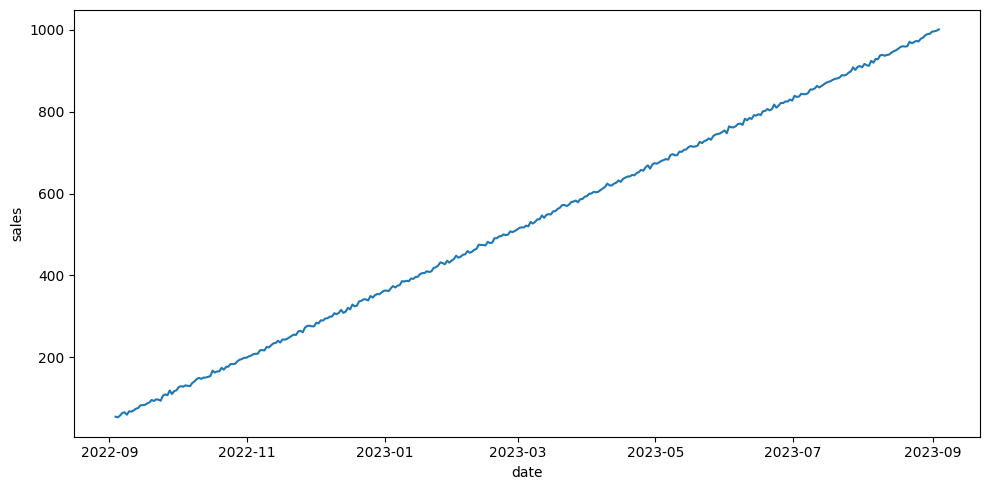

In [13]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)

plt.tight_layout()

plt.show()

Paso 2. Análisis de la serie temporal


Descomposición de la serie

In [14]:
decomposition = seasonal_decompose(ts_total, period = 12)
decomposition

Análisis de la tendencia

Obtenemos la tendencia, la misma se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos a la componente TREND de la descomposición y luego la gráficamos junto a la serie temporal.


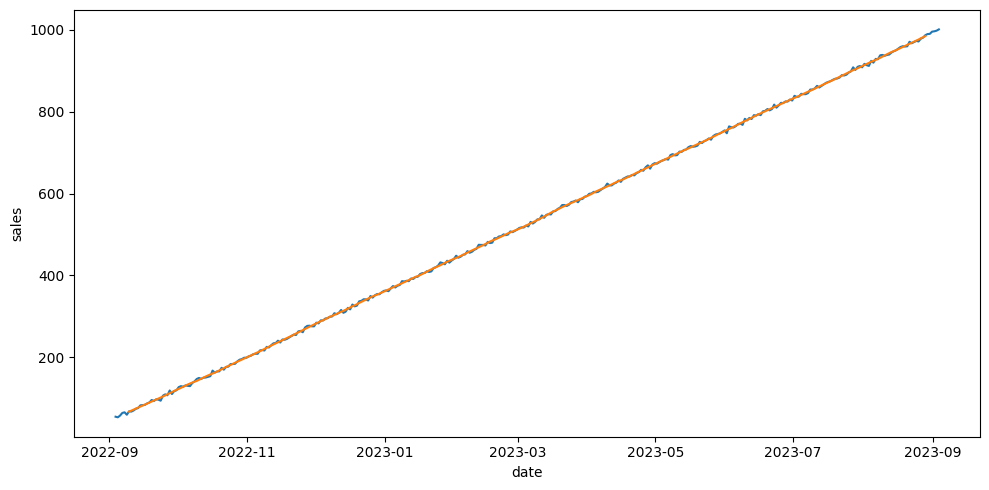

In [41]:
#Obtenemos trend y luego la gráficamos junto a la serie temporal.

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Conclusión acerca de la Tendencia: Se aprecia una tendencia ascendente, lo que indica que el número de ventas ha aumentado a lo largo del tiempo, se confirma una clara tendencia positiva a lo largo de los meses del años.

Análisis de la estacionalidad

El análisis de estacionalidad en series temporales es una técnica que busca identificar patrones recurrentes o ciclos que se repiten a intervalos regulares. Al realizar un análisis de estacionalidad, se pueden obtener varias insights y observaciones, incluyendo:
1-Patrones Temporales Recurrentes
2-Identificación de Ciclos
3-Ajuste de Modelos
4-Identificación de Tendencias a Largo Plazo
5-Previsión y Planificación
6-Visualización de Patrones Estacionales
7-Anomalías Estacionales

Para acceder a su información recurrimos a la componente seasonal de la descomposición.

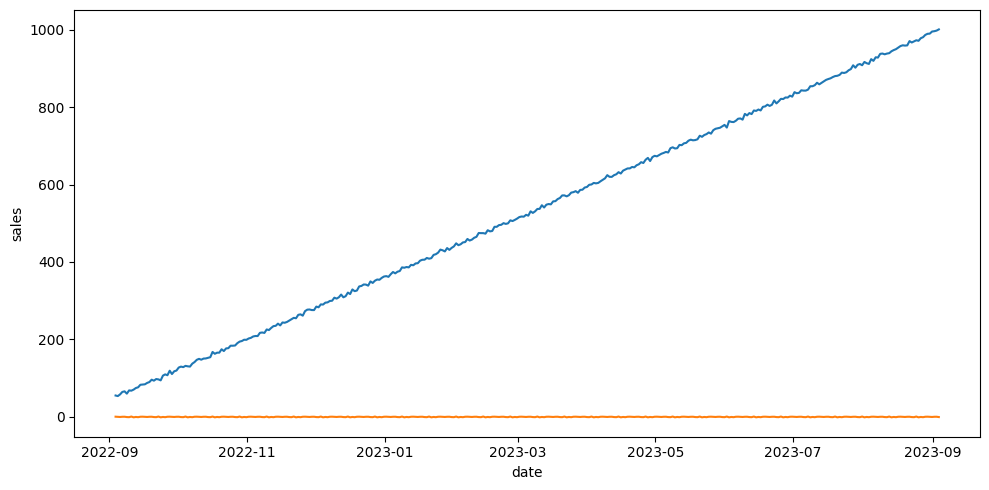

In [54]:
#Obtenemos la componente seasonal y luego la gráficamos junto a la serie temporal.

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Conclusión de la Estacionalidad: No existe estacionalidad alguna.
Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:

In [43]:
#Prueba de Dickey-Fuller (Dickey-Fuller test)

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_total)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el valor p es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria

Análisis de la variabilidad


La variabilidad implica el estudio de los residuos: Consiste en cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos a la componente residual de la descomposición.

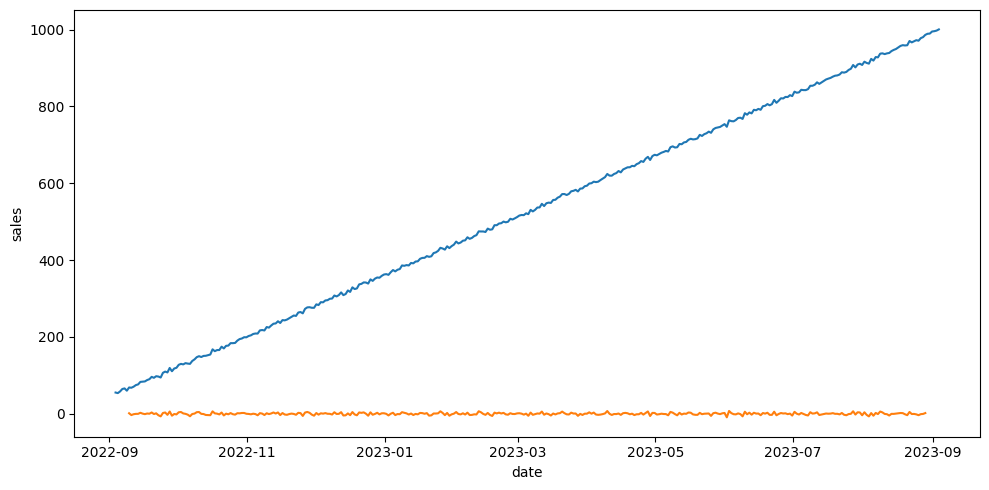

In [44]:
#Obtenemos la componente residual y luego la gráficamos junto a la serie temporal.

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Se considera que tiene una baja variabilidad dado que no existen saltos grandes que permitan evidenciar grandes diferencias.

Conclusión:
¿Cuál es el tensor de la serie temporal? 366,1,1
¿Cuál es la tendencia? Alsista
¿Es estacionaria? NO
¿Existe variabilidad o presencia de ruido? No

Análisis de la autocorrelación
La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

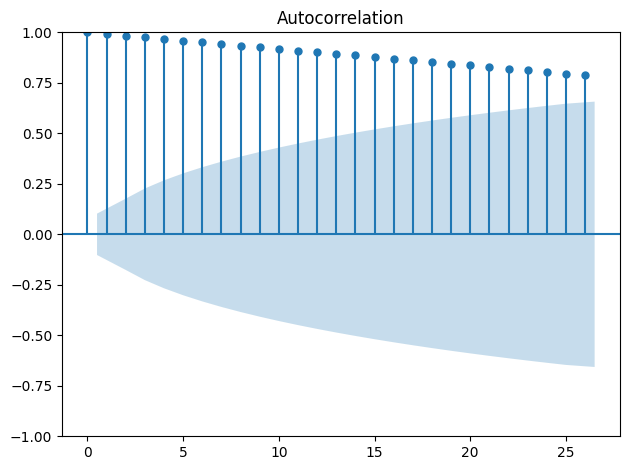

In [45]:
#Mediante el siguiente gráfico de barras (plot_acf) podemos observar los valores de autocorrelación en diferentes retrasos.
#Cada barra en el gráfico representa la correlación entre la serie temporal y sus valores pasados a un cierto número de períodos de tiempo.


plot_acf(ts_total)

plt.tight_layout()

plt.show()


Conclusión:  Se pueden observar barras que sobresalen por encima de las bandas de confianza, podemos inferir que hay autocorrelación en esos retrasos. Existe evidencia para determinar que hay una AUTOCORRELACIÓN alta a pesar de que a medida que avanzamos en la serie temporal, la autocorrelación va disminuyendo periódicamente.

Paso 3: Entrena un ARIMA

Lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla:

In [46]:
ts_stationary = ts_total.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Ahora la serie si es estacionaria, y podemos aplicar el método ARIMA automático:

In [47]:
# Partición: Rompemos el dataset en conjunto de entrenamiento y conjunto de prueba (los últimos 365 días)
df_train, df_test = ts_total.iloc[:-183], ts_total.iloc[-183:]

In [48]:
model = auto_arima(df_train,seasonal = False, trace = True)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1042.376, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=988.332, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=925.761, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1098.123, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=927.424, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=927.414, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=929.412, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1098.912, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.910 seconds


Paso 3: Predicción del modelo

In [49]:
#Realizamos la predicción de 20 días
forecast = model.predict(20)
forecast

2023-03-05 17:10:08.079328    525.427057
2023-03-06 17:10:08.079328    528.015321
2023-03-07 17:10:08.079328    530.603585
2023-03-08 17:10:08.079328    533.191849
2023-03-09 17:10:08.079328    535.780113
2023-03-10 17:10:08.079328    538.368377
2023-03-11 17:10:08.079328    540.956641
2023-03-12 17:10:08.079328    543.544905
2023-03-13 17:10:08.079328    546.133169
2023-03-14 17:10:08.079328    548.721433
2023-03-15 17:10:08.079328    551.309697
2023-03-16 17:10:08.079328    553.897961
2023-03-17 17:10:08.079328    556.486225
2023-03-18 17:10:08.079328    559.074489
2023-03-19 17:10:08.079328    561.662753
2023-03-20 17:10:08.079328    564.251017
2023-03-21 17:10:08.079328    566.839281
2023-03-22 17:10:08.079328    569.427545
2023-03-23 17:10:08.079328    572.015809
2023-03-24 17:10:08.079328    574.604073
Freq: D, dtype: float64

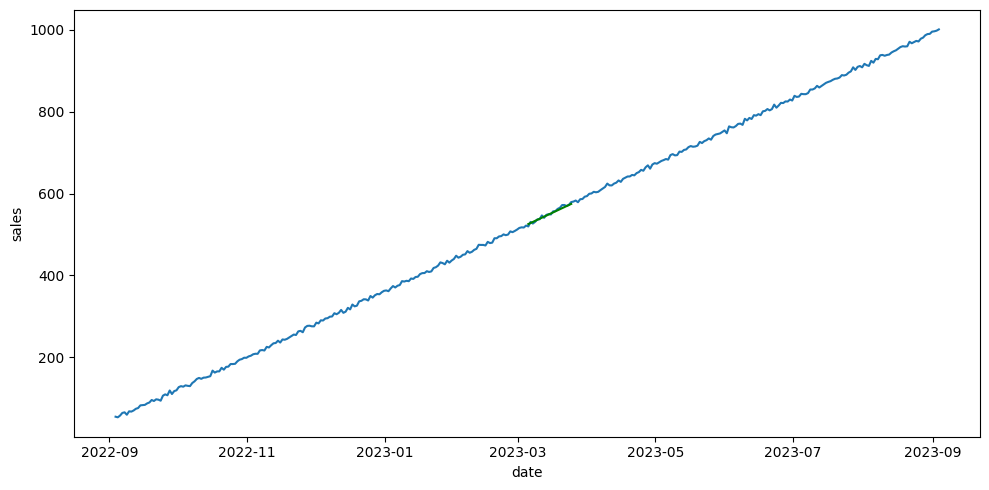

In [50]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_total)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()


In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -459.881
Date:                Sat, 16 Dec 2023   AIC                            925.761
Time:                        12:08:04   BIC                            935.373
Sample:                    09-03-2022   HQIC                           929.658
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5883      0.017    148.906      0.000       2.554       2.622
ma.L1         -0.9294      0.029    -32.255      0.000      -0.986      -0.873
sigma2         9.0684      1.065      8.515      0.000       6.981      11.156
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.59   Prob(JB):                         0.50
Heteroskedasticity (H):               0.83   Skew:                             0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
#Guardamos el modelo
dump(model, open("../models/SARIMAX(0, 1, 1)_42.sav", "wb"))

In [53]:
#Guardamos el dataset final (ts_total)
ts_total.to_csv("../data/processed/data.csv")